<a href="https://colab.research.google.com/github/hexlive6363/SSD_FINAL/blob/main/finalcall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,label,tweet,cleaned_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset cant update facebook texting might cry result school today also blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving im mad cant see
5,0,@Kwesidei not the whole crew,whole crew
6,0,Need a hug,need hug
7,0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?",hey long time see yes rain bit bit lol im fine thanks hows
8,0,@Tatiana_K nope they didn't have it,nope didnt
9,0,@twittera que me muera ?,que muera


,count
label,
0,747555
1,296337


Training model: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


ENTER THE LINEs upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!


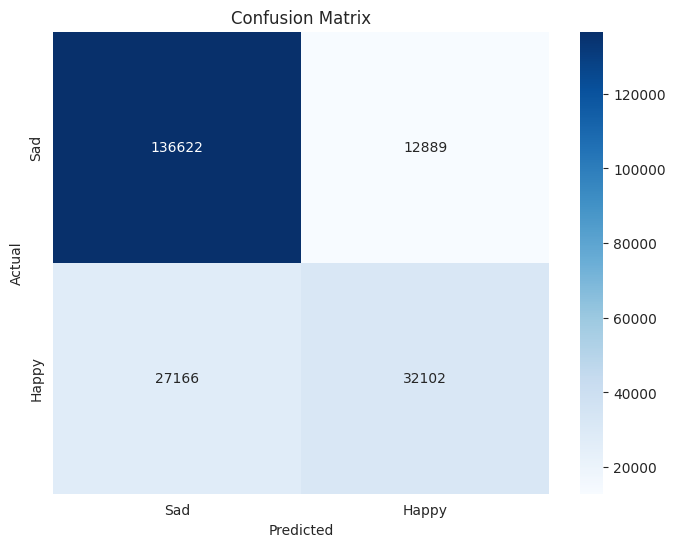

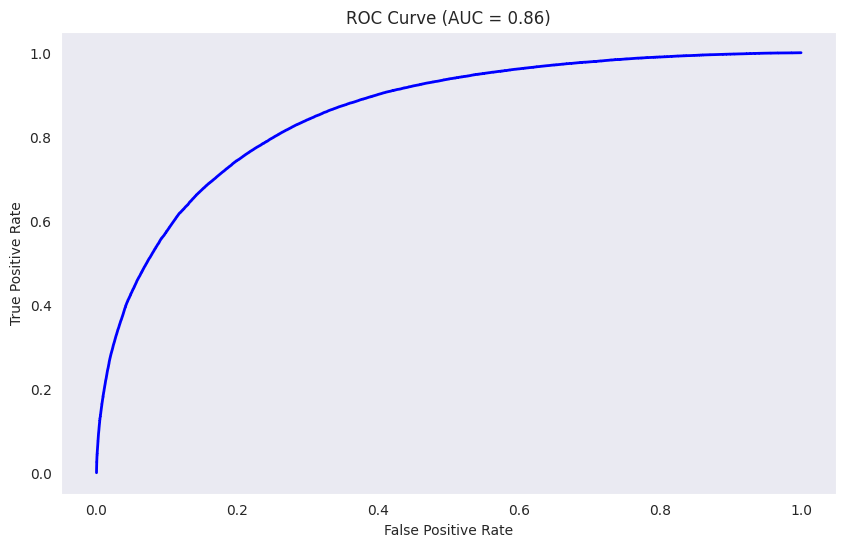

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1276, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr

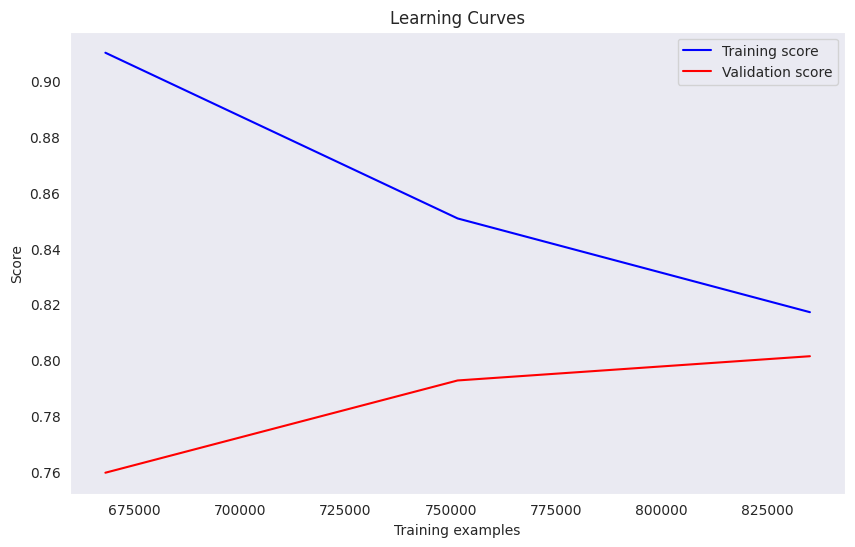

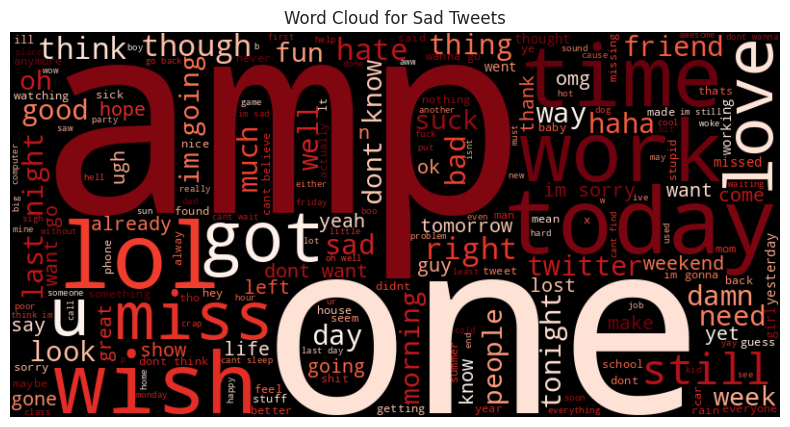

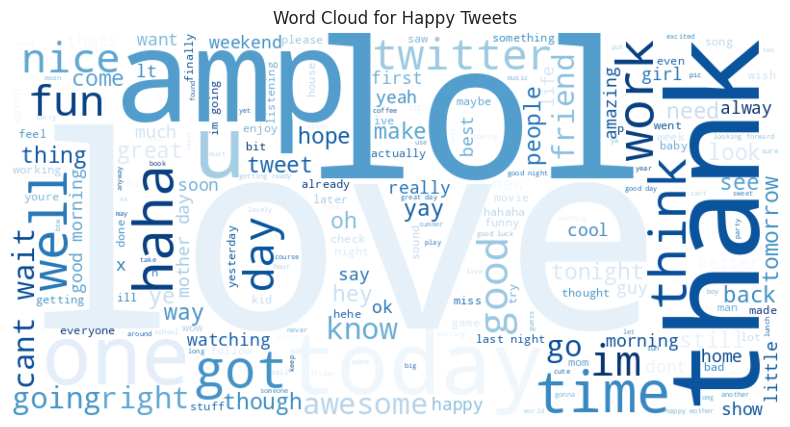

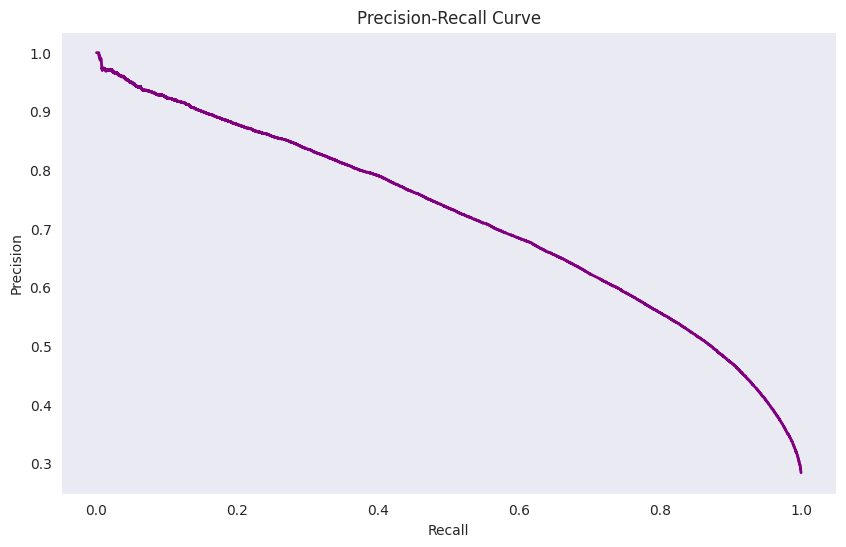

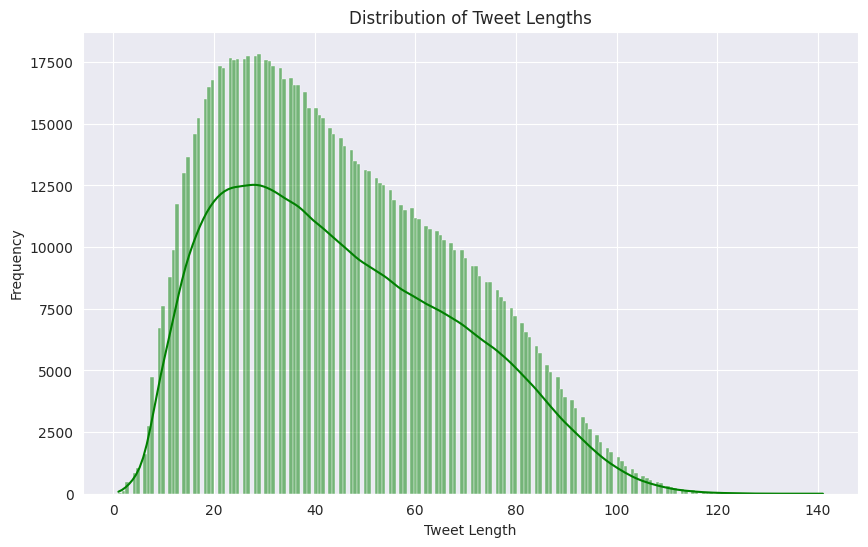

<ipython-input-1-cc339dc50244>:256: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, palette='viridis')


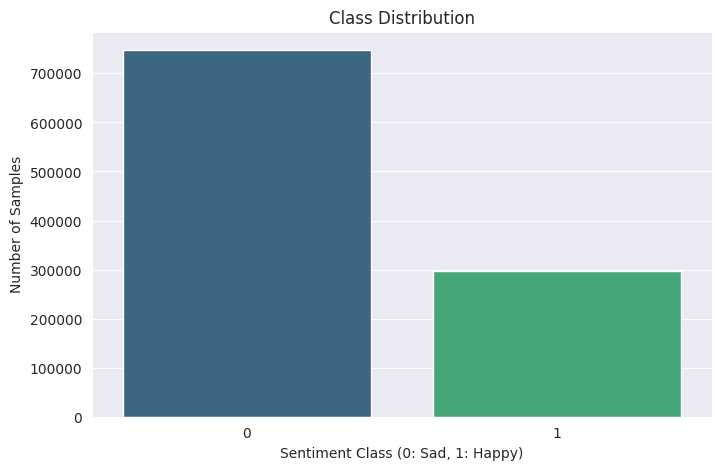

In [1]:
import pandas as pd
import numpy as np
import re
import pickle

# For text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For splitting the data
from sklearn.model_selection import train_test_split, learning_curve

# For evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

# For plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from tqdm import tqdm
import warnings

# For HTML display styling
from IPython.display import display, HTML

# Configure plotting style
%matplotlib inline
sns.set_style('darkgrid')

# Suppress warnings for fit failures
warnings.filterwarnings("ignore", category=UserWarning, message=".*FitFailedWarning.*")

# Utility function to display outputs with a blue border
def display_with_border(content):
    display(HTML(f"""
    <div style='border: 2px solid blue; padding: 10px;'>
        {content}
    </div>
    """))

# Step 1: Load the cleaned data with error handling
def load_data(file_path):
    try:
        return pd.read_csv(file_path, encoding='latin-1')
    except pd.errors.ParserError as e:
        display_with_border(f"Error reading the CSV file: {e}")
        return None

file_path = 'cleaned_tweets.csv'
df = load_data(file_path)

if df is None:
    raise SystemExit("Failed to load data. Exiting...")

display_with_border(df.head(10).to_html())

# Step 2: Advanced Data Cleaning
# Check if required columns exist
if 'cleaned_tweet' not in df.columns or 'label' not in df.columns:
    raise KeyError("Missing required columns: 'cleaned_tweet' or 'label'")

# Remove duplicates and clean the data
df = df.drop_duplicates(subset=['cleaned_tweet']).reset_index(drop=True)
df = df.dropna(subset=['cleaned_tweet'])
df = df[df['cleaned_tweet'].str.strip().astype(bool)].reset_index(drop=True)
df = df[df['label'].isin([0, 4])]

# Convert labels: 4 -> 1
df['label'] = df['label'].replace({4: 1})

# Ensure there are samples from both classes
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

if len(df_class_0) == 0 or len(df_class_1) == 0:
    raise ValueError("The dataset must contain samples from both classes (0 and 1).")

display_with_border(df['label'].value_counts().to_frame().to_html())

# Step 3: Define features and labels
X = df['cleaned_tweet']
y = df['label']

# Step 4: Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=15000, stop_words='english', ngram_range=(1, 3)
)
X_vectorized = vectorizer.fit_transform(X)

display_with_border("TF-IDF vectorization complete.")

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

display_with_border(f"Training set size: {X_train.shape[0]}<br>Testing set size: {X_test.shape[0]}")

# Step 6: Initialize and train the Logistic Regression model with a progress bar
model = LogisticRegression(
    max_iter=30000, solver='liblinear', random_state=42, C=1.0
)
for _ in tqdm(range(1), desc="Training model"):
    model.fit(X_train, y_train)

display_with_border("Model training complete.")

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
display_with_border(f"Model Accuracy on Test Set: {accuracy:.4f}")

# Display classification report
report = classification_report(y_test, y_pred, target_names=['Sad', 'Happy'])
display_with_border(f"<pre>{report}</pre>")

# Step 8: Save the model using pickle
with open('L.pkl', 'wb') as model_file:
    pickle.dump((model, vectorizer), model_file)
display_with_border("Model saved successfully as 'LATEST.pkl'.")

# Step 9: Function to predict sentiment of input text
def preprocess_text(text):
    # Text preprocessing steps
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    return text

def predict_sentiment(text):
    # Preprocess the input text
    cleaned_text = preprocess_text(text)
    # Vectorize the text
    text_vectorized = vectorizer.transform([cleaned_text])
    # Predict the label
    prediction = model.predict(text_vectorized)[0]
    # Map the label to sentiment
    sentiment = 'Happy' if prediction == 1 else 'Sad'
    return sentiment

# Input a line of text and get the sentiment label
input_text = input("ENTER THE LINE")
sentiment = predict_sentiment(input_text)
display_with_border(f"The predicted sentiment is: {sentiment}")

# Step 10: Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Sad', 'Happy'],
    yticklabels=['Sad', 'Happy'],
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
display_with_border("Confusion Matrix displayed.")

# Step 11: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.grid()
plt.show()
display_with_border("ROC Curve displayed.")

# Step 12: Plot Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    model, X_vectorized, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation score', color='red')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.grid()
plt.show()
display_with_border("Learning Curves displayed.")

# Step 13: Plot Word Clouds for Sentiment Classes
sad_words = ' '.join(df[df['label'] == 0]['cleaned_tweet'])
happy_words = ' '.join(df[df['label'] == 1]['cleaned_tweet'])

# Generate word cloud for Sad tweets
sad_wordcloud = WordCloud(
    width=800, height=400, max_words=200, background_color='black', colormap='Reds'
).generate(sad_words)
plt.figure(figsize=(10, 5))
plt.imshow(sad_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sad Tweets')
plt.show()
display_with_border("Word Cloud for Sad Tweets displayed.")

# Generate word cloud for Happy tweets
happy_wordcloud = WordCloud(
    width=800, height=400, max_words=200, background_color='white', colormap='Blues'
).generate(happy_words)
plt.figure(figsize=(10, 5))
plt.imshow(happy_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Happy Tweets')
plt.show()
display_with_border("Word Cloud for Happy Tweets displayed.")

# Step 14: Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()
display_with_border("Precision-Recall Curve displayed.")

# Step 15: Histogram of Tweet Lengths
tweet_lengths = df['cleaned_tweet'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(tweet_lengths, kde=True, color='green')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()
display_with_border("Distribution of Tweet Lengths displayed.")

# Step 16: Bar Chart of Class Distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, palette='viridis')
plt.xlabel('Sentiment Class (0: Sad, 1: Happy)')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()
display_with_border("Class Distribution displayed.")


,label,tweet,cleaned_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset cant update facebook texting might cry result school today also blah
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",behaving im mad cant see
5,0,@Kwesidei not the whole crew,whole crew
6,0,Need a hug,need hug
7,0,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?",hey long time see yes rain bit bit lol im fine thanks hows
8,0,@Tatiana_K nope they didn't have it,nope didnt
9,0,@twittera que me muera ?,que muera


,count
label,
0,747555
1,731312


Training model: 100%|██████████| 1/1 [00:20<00:00, 20.70s/it]


ENTERhi it is good


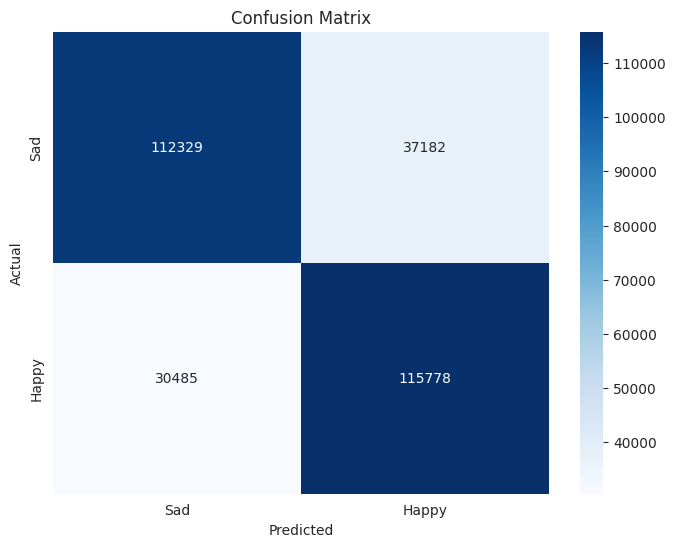

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:177: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


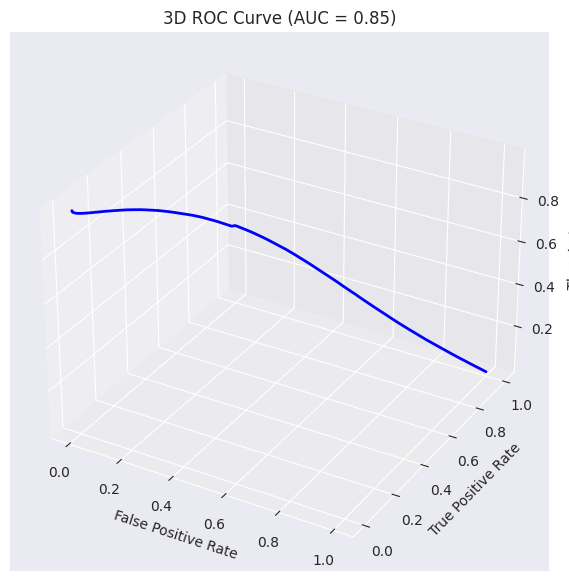

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1276, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr

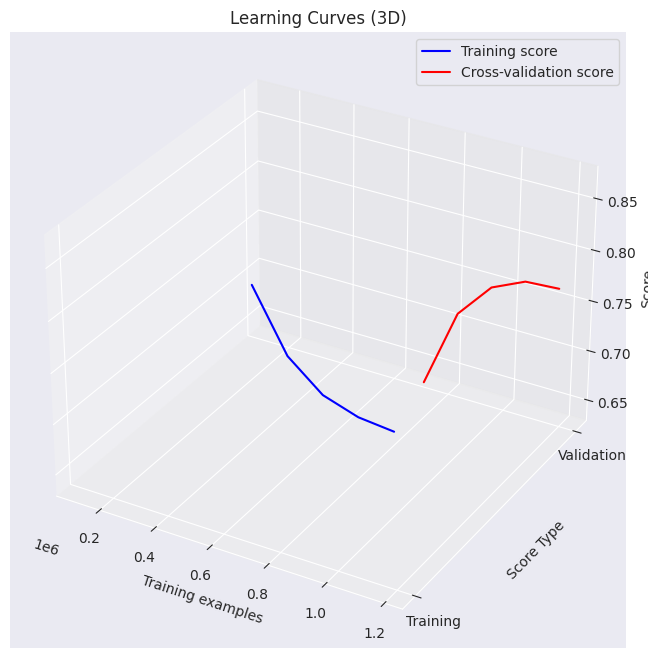

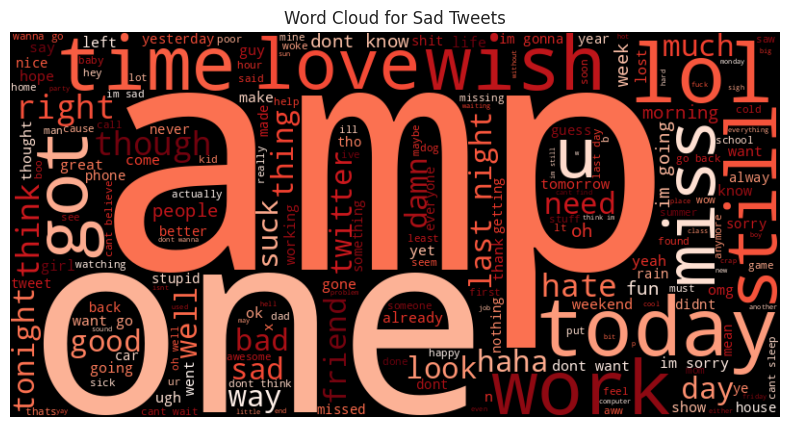

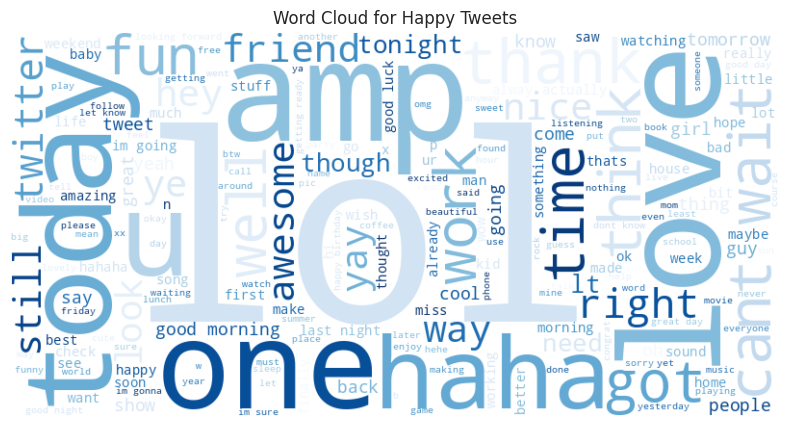

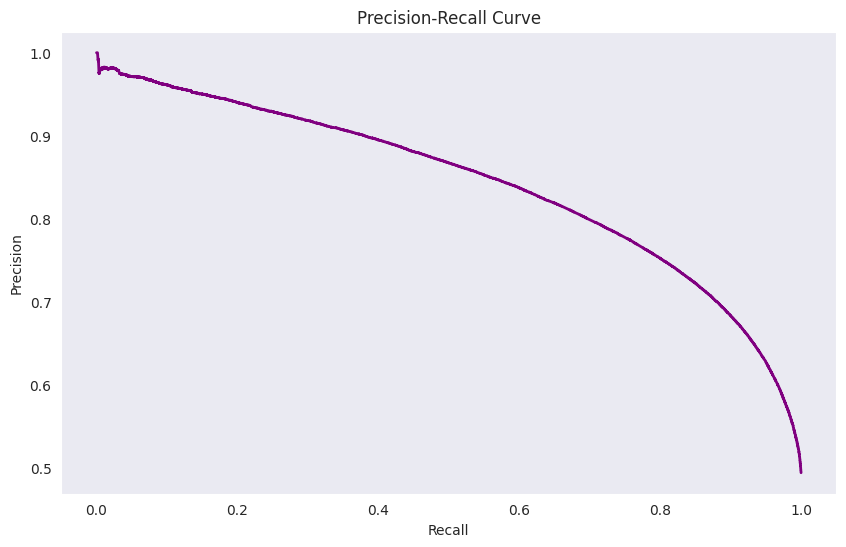

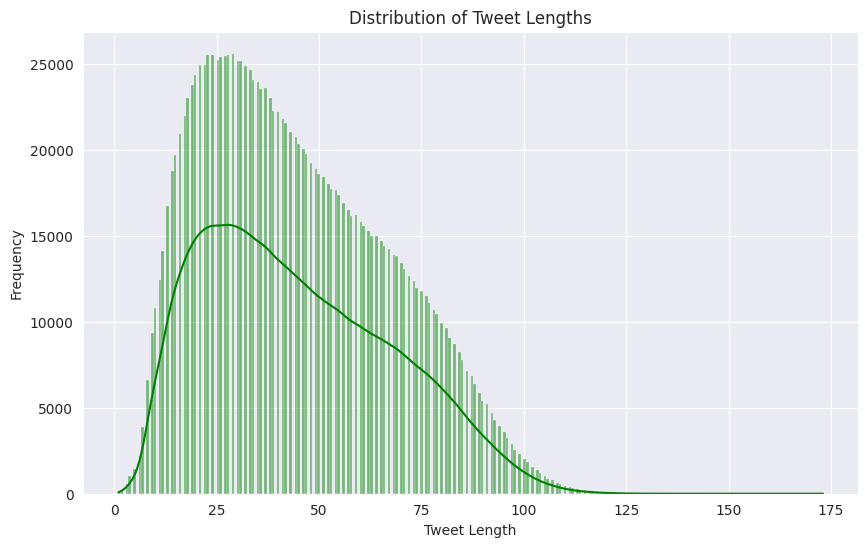

<ipython-input-7-316c6999fb82>:256: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values, palette='viridis')


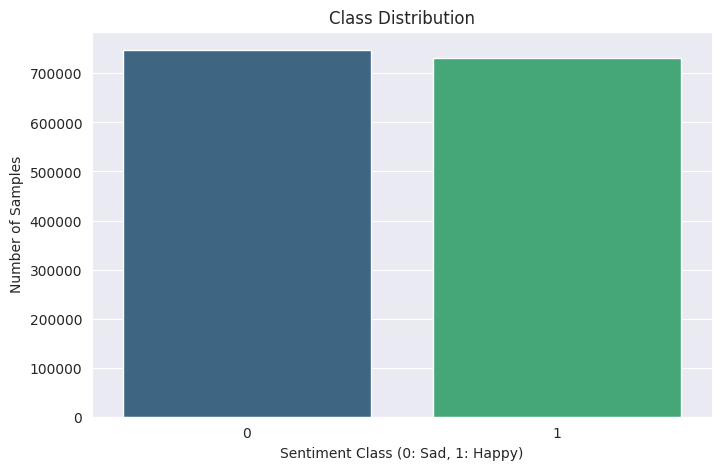